https://engine-aiearth.aliyun.com/docs/page/api?d=07f36f#heading-22

https://engine-aiearth.aliyun.com/?spm=a2cvf.28031243.0.0.5dc743d42pbV5o#/utility/auth-token

# 收集MODIS所有有效数据

In [1]:
import aie

aie.Authenticate(token='a883697366926140b70e960b7a5f2a5f')
aie.Initialize()

计算资源初始化中，请等待...
计算资源初始化完成.


In [3]:
import geopandas as gpd
# 读取shp文件
shapefile_path = '/root/Download/Modis-algae-aliyun/local-data/taihu.shp'
gdf = gpd.read_file(shapefile_path)

# 假设shp文件中只有一个几何对象，取第一个
geometry = gdf.geometry.iloc[0]
print(geometry)
# 输出((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, ...

# 将geopandas的geometry对象转换为ee.Geometry
coords = list(geometry.exterior.coords)
flattened_coords = [coord for point in coords for coord in point]
taihu = aie.Geometry.Polygon(flattened_coords)
# 构造Polygon。输入参数支持GeoJSON 'Polygon'类型格式的坐标点集，
# 同时也支持包含偶数个数字的一维List，例如aie.Geometry.Polygon([aLng, aLat, bLng, bLat, ...])。
# 需注意，输入的坐标点将以EPSG:4326坐标系进行解析。

# 打印ee.Geometry对象以验证
print(taihu)

POLYGON ((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, 120.00611934273043 31.40820067954559, 120.0213482061359 31.420557311454473, 120.02780893606551 31.42562749019076, 120.03023170978913 31.42966374717613, 120.0274051404449 31.43596389857637, 120.02025218945138 31.447873965243872, 120.00888822698595 31.45166321445573, 120.01067646473432 31.455403102339847, 120.01448368058568 31.46224277412878, 120.01806015608244 31.467556706624215, 120.02342486932757 31.473017934057427, 120.02827041677476 31.47729813281918, 120.02902032292732 31.479561147303205, 120.03525031250228 31.481725718642263, 120.03871141782174 31.48452974796941, 120.04223020822982 31.48275879185581, 120.04678733023371 31.479659537995836, 120.05734370145801 31.476461787529658, 120.06017027080222 31.47651098451827, 120.06380443138762 31.471541958062947, 120.06276609979179 31.468442332717288, 120.06345832085567 31.46578542930369, 120.06703479635243 31.4656870240255, 120.07078432711515 31.46052060

/tmp/ipykernel_1064/1116589033.py:55: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1116589033.py:55: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1116589033.py:55: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1116589033.py:55: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1116589033.py:55: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1116589033.py:55: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1116589033.py:55: UserWarning: Glyph 21450 (\N{CJK UNIFIED IDEOGRAPH-53CA}) missing from current font.
  plt.tight_l

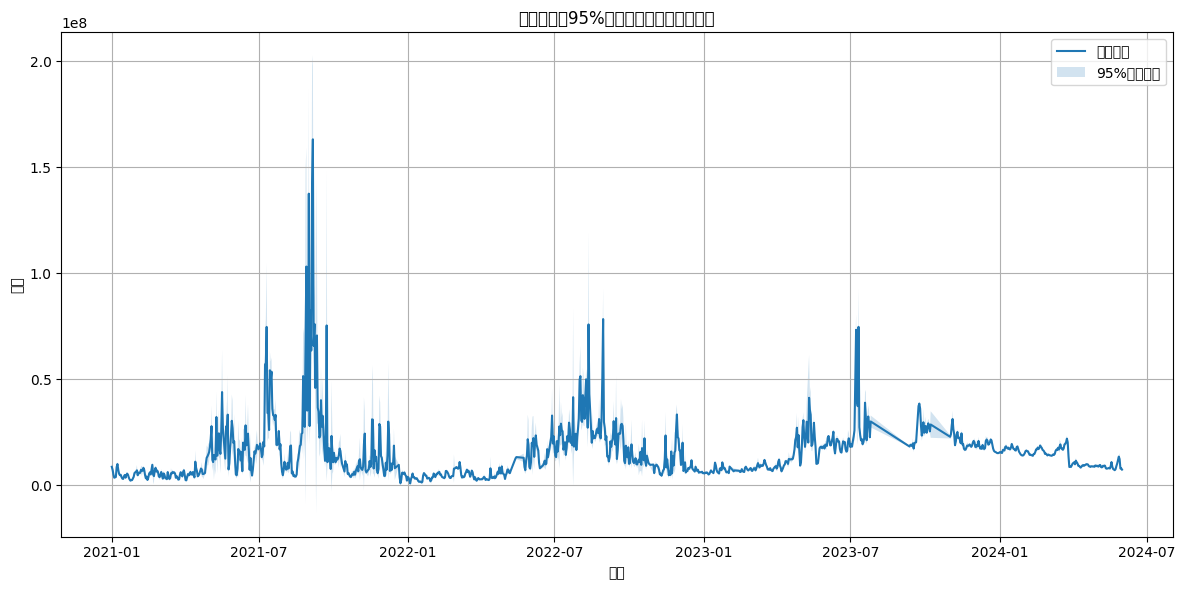

In [4]:
import datetime
import csv
import aie
import pandas as pd
import numpy as np
import chardet
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 步骤1: 数据准备
csv_file = '/root/Download/Modis-algae-aliyun/aie-taihu/00-lanshanzui.csv'

# 检测文件编码
with open(csv_file, 'rb') as f:
    result = chardet.detect(f.read())

# 使用探测到的编码读取文件
df = pd.read_csv(csv_file, encoding=result['encoding'])

# 将日期列转换为日期时间格式
df['date'] = pd.to_datetime(df['date'])

# 设置日期为索引
df.set_index('date', inplace=True)

# 对密度列进行线性插值
df['density'] = df['density'].interpolate(method='linear')

# 按日期分组并计算每日的统计数据
daily_stats = df['density'].resample('D').agg(['mean', 'std', 'count'])

# 计算95%置信区间
confidence_interval = 1.96 * daily_stats['std'] / np.sqrt(daily_stats['count'])

# 计算置信区间的上下限
daily_stats['lower_ci'] = daily_stats['mean'] - confidence_interval
daily_stats['upper_ci'] = daily_stats['mean'] + confidence_interval

# 对平均值和置信区间上下限进行线性插值
daily_stats_interpolated = daily_stats.interpolate(method='linear')

# 绘制密度和置信区间
plt.figure(figsize=(12, 6))
plt.plot(daily_stats_interpolated.index, daily_stats_interpolated['mean'], label='平均密度')
plt.fill_between(daily_stats_interpolated.index, daily_stats_interpolated['lower_ci'], daily_stats_interpolated['upper_ci'], alpha=0.2, label='95%置信区间')
plt.xlabel('日期')
plt.ylabel('密度')
plt.title('藻类密度及95%置信区间（线性插值后）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:

# 步骤2: 收集所有有效数据
valid_features = {
    'ndci': [],
    'ndvi': [],
    'evi': [],
    'ndwi': [],
    'b1': [],
    'b2': [],
    'b5': []
}
valid_density_mean = []
valid_density_lower = []
valid_density_upper = []

roi = aie.Geometry.BBox(119.89, 31.212, 119.90, 31.222)

def mask_clouds(image):
    qa = image.select('state_1km')
    cloud_bit_mask = 1 << 10
    mask = qa.bitwiseAnd(aie.Image.constant(cloud_bit_mask))
    return mask

处理日期 2024_01_05 的数据时出错 (尝试 1/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "9984aadc-91f5-11ef-8794-00155d224f02"}
处理日期 2024_01_05 的数据时出错 (尝试 2/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "9c5cefc6-91f5-11ef-8794-00155d224f02"}
处理日期 2024_01_05 的数据时出错 (尝试 3/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "9f0d5ed6-91f5-11ef-8794-00155d224f02"}
处理日期 2024_01_05 的数据时出错 (尝试 4/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "a1c8af40-91f5-11ef-8794-00155d224f02"}
处理日期 2024_01_05 的数据时出错 (尝试 5/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "a46a3976-91f5-11ef-8794-00155d224f02"}
处理日期 2024_01_05 的数据时出错 (尝试 6/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "a7284fc2-91f5-11ef-8794-00155d224f02"}
处理日期 2024_01_05 的数据时出错 (尝试 7/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "aa242bd8-91f5-11ef-8794-00155d224f02"}
处理日期 2024_01_05 的数据时出错 (尝试 8/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"t

/tmp/ipykernel_1064/1487081319.py:107: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1487081319.py:107: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1487081319.py:107: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1487081319.py:107: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1487081319.py:107: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1487081319.py:107: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/1487081319.py:107: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.

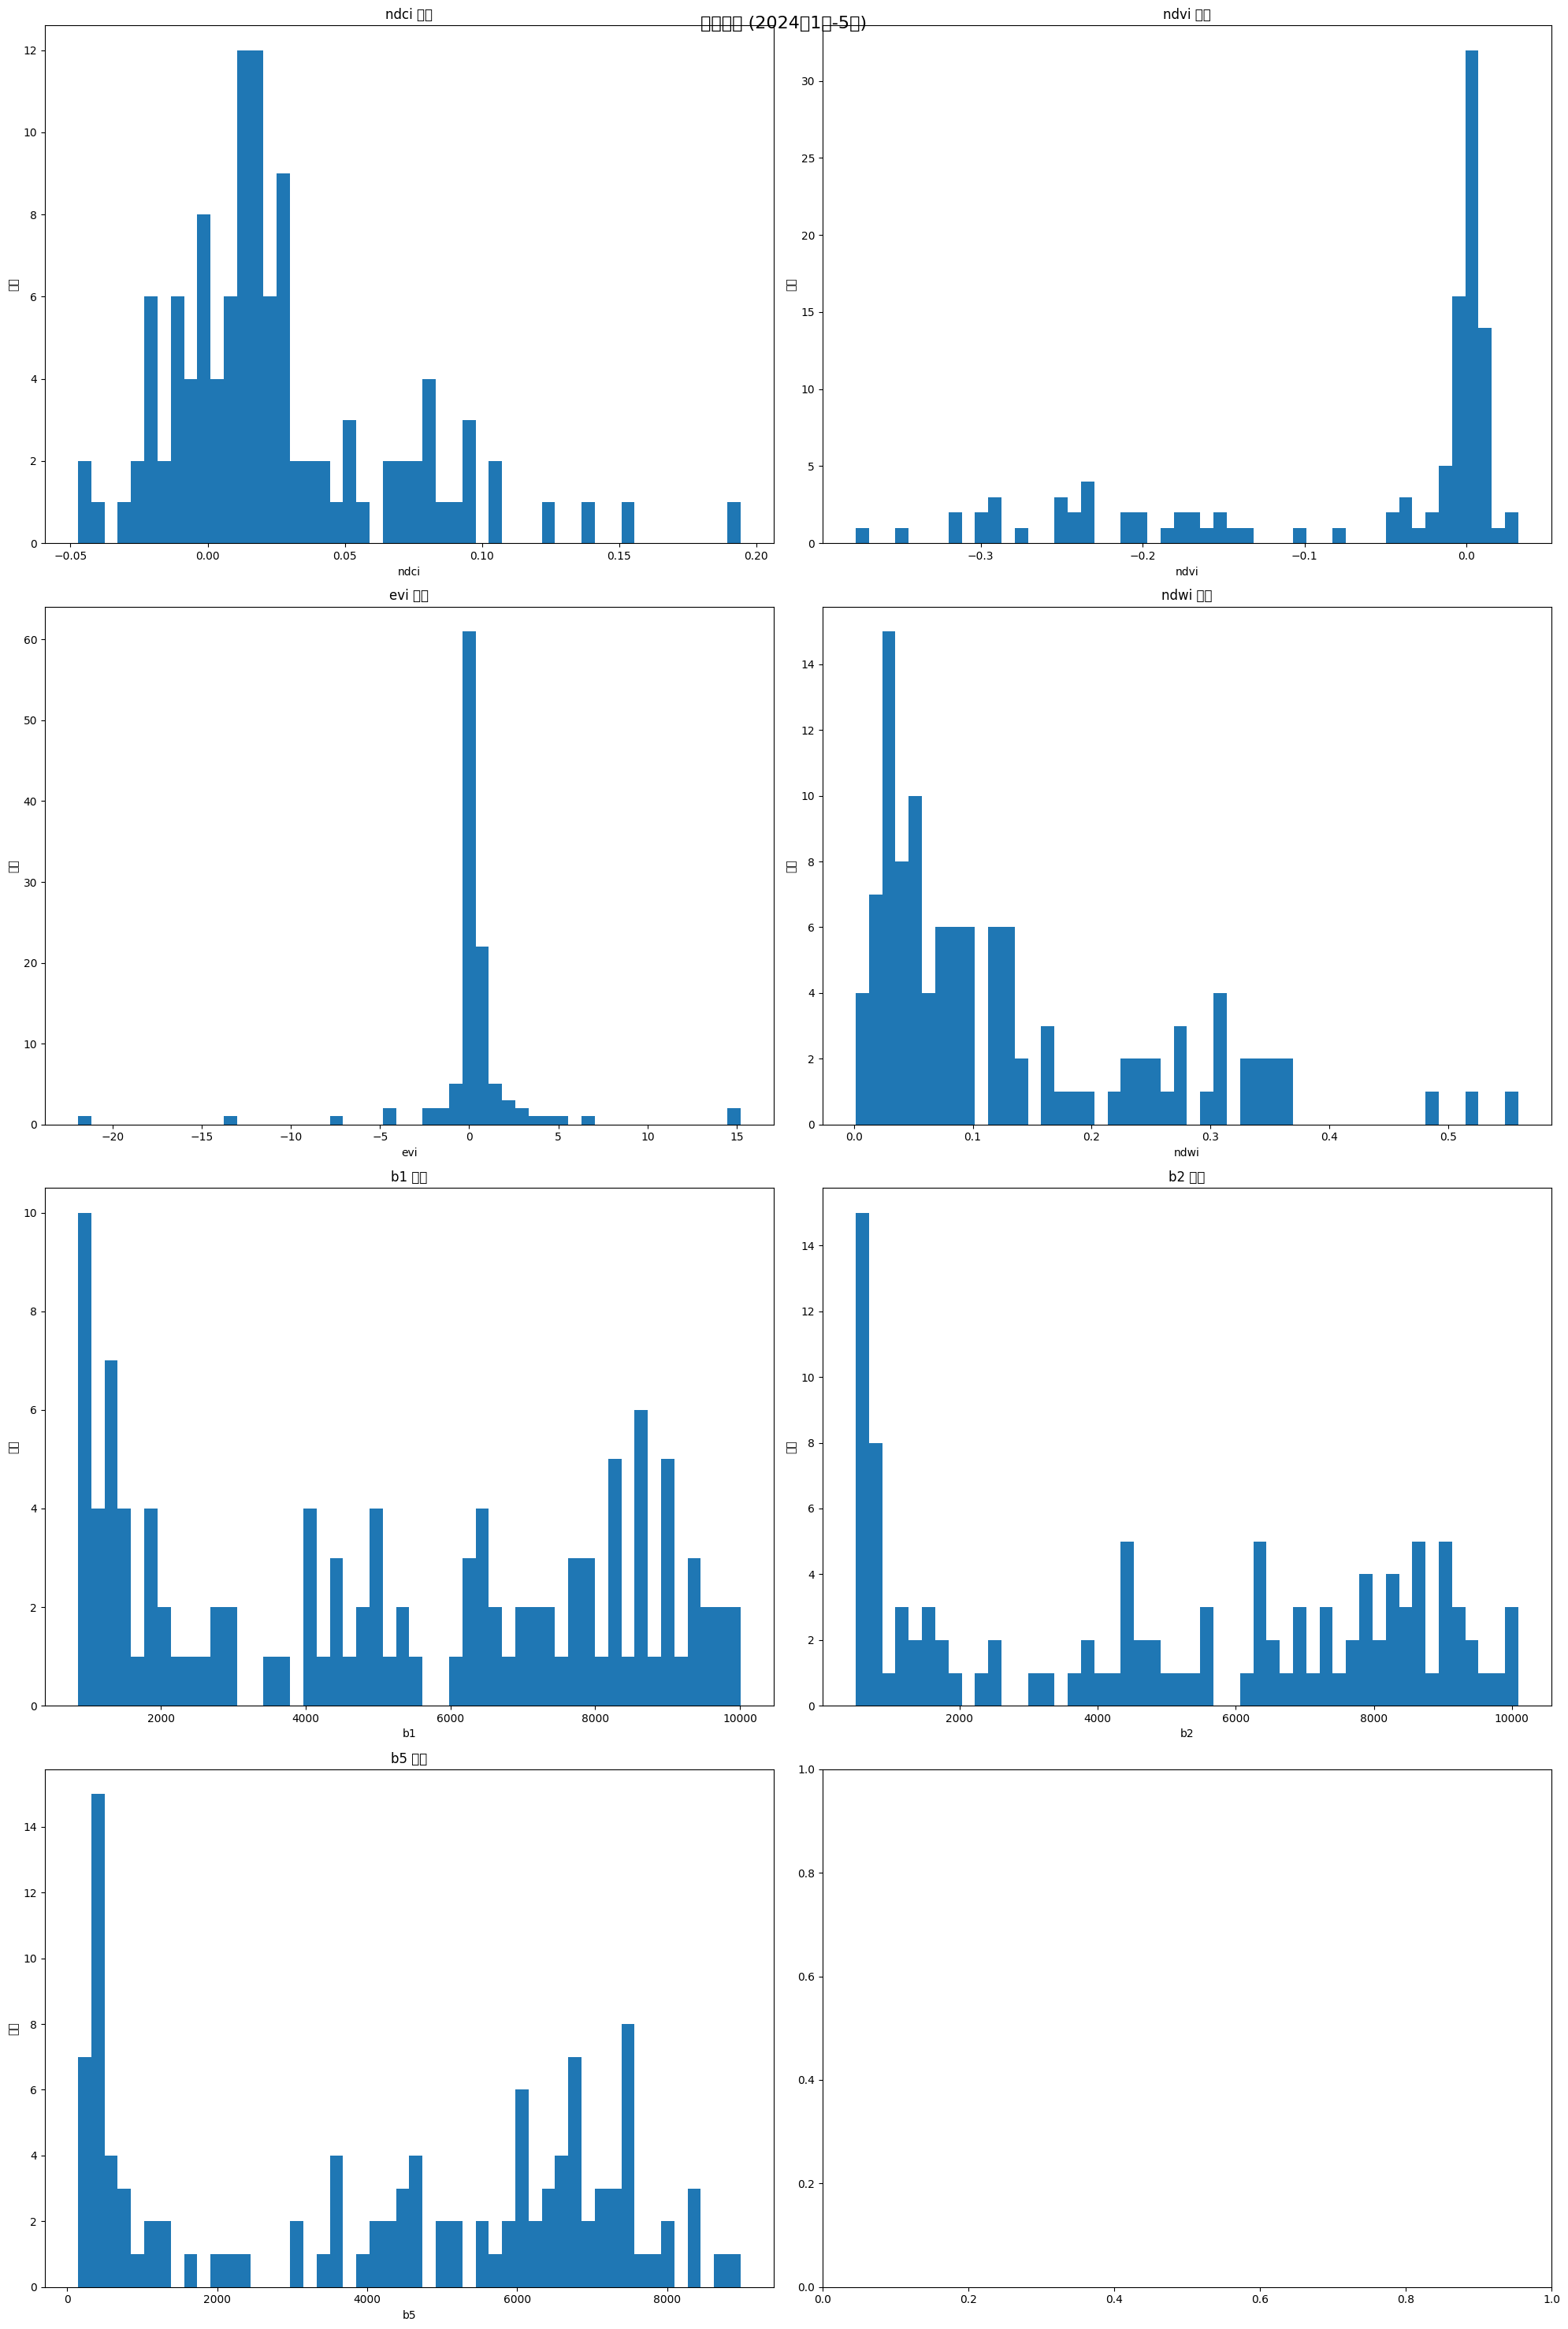

ValueError: x and y must have same first dimension, but have shapes (109,) and (113,)

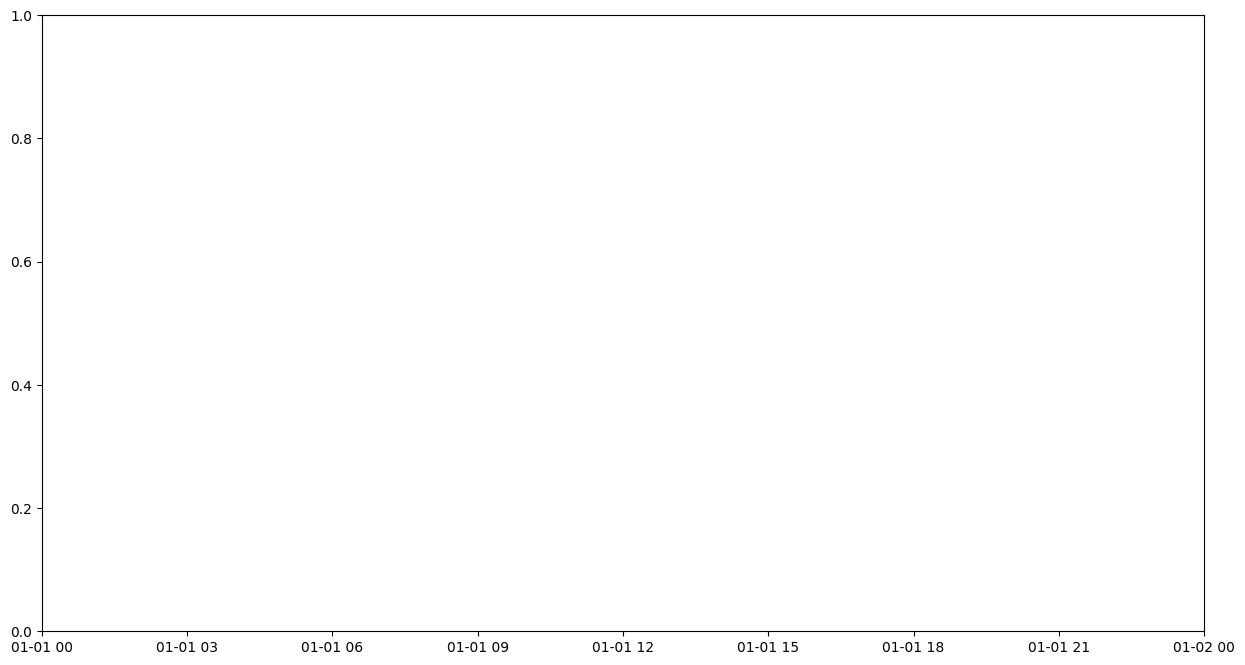

In [7]:

from aiearth.core.error.aie_error import AIEError
start_date = datetime.date(2024, 1, 1)
end_date = datetime.date(2024, 5, 31)
delta = datetime.timedelta(days=1)
valid_features = {
    'ndci': [],
    'ndvi': [],
    'evi': [],
    'ndwi': [],
    'b1': [],
    'b2': [],
    'b5': []
}
valid_density_mean = []
valid_density_lower = []
valid_density_upper = []
valid_dates = []

while start_date <= end_date:
    date_str = start_date.strftime("%Y_%m_%d")
    retry_count = 0
    while retry_count < 10:
        try:
            img = aie.Image(f'MODIS_MOD09GA_061_{date_str}')\
                     .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'state_1km'])
            
            cloud_mask = mask_clouds(img)
            ndci = img.normalizedDifference(['sur_refl_b04', 'sur_refl_b03']).rename(['ndci'])
            ndvi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename(['ndvi'])
            evi = img.expression(
                '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
                {'NIR': img.select('sur_refl_b02'), 'RED': img.select('sur_refl_b01'), 'BLUE': img.select('sur_refl_b03')}
            ).rename(['evi'])
            ndwi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b05']).rename(['ndwi'])
            
            ndci_masked = ndci.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            ndvi_masked = ndvi.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            evi_masked = evi.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            ndwi_masked = ndwi.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            b1_masked = img.select('sur_refl_b01').where(cloud_mask.Not(), aie.Image.constant(999999999999))
            b2_masked = img.select('sur_refl_b02').where(cloud_mask.Not(), aie.Image.constant(999999999999))
            b5_masked = img.select('sur_refl_b05').where(cloud_mask.Not(), aie.Image.constant(999999999999))
            
            current_date = pd.to_datetime(start_date)
            if current_date in daily_stats_interpolated.index:
                mean_density = daily_stats_interpolated.loc[current_date, 'mean']
                lower_ci = daily_stats_interpolated.loc[current_date, 'lower_ci']
                upper_ci = daily_stats_interpolated.loc[current_date, 'upper_ci']
                
                ndci_values = ndci_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndci').getInfo()
                ndvi_values = ndvi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndvi').getInfo()
                evi_values = evi_masked.sample(roi, 100, 1, 0, True).aggregate_array('evi').getInfo()
                ndwi_values = ndwi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndwi').getInfo()
                b1_values = b1_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b01').getInfo()
                b2_values = b2_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b02').getInfo()
                b5_values = b5_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b05').getInfo()
                
                valid_indices = [i for i in range(len(ndci_values)) if ndci_values[i] < 999999999]
                
                if valid_indices:
                    valid_features['ndci'].extend([ndci_values[i] for i in valid_indices])
                    valid_features['ndvi'].extend([ndvi_values[i] for i in valid_indices])
                    valid_features['evi'].extend([evi_values[i] for i in valid_indices])
                    valid_features['ndwi'].extend([ndwi_values[i] for i in valid_indices])
                    valid_features['b1'].extend([b1_values[i] for i in valid_indices])
                    valid_features['b2'].extend([b2_values[i] for i in valid_indices])
                    valid_features['b5'].extend([b5_values[i] for i in valid_indices])
                    valid_density_mean.extend([mean_density] * len(valid_indices))
                    valid_density_lower.extend([lower_ci] * len(valid_indices))
                    valid_density_upper.extend([upper_ci] * len(valid_indices))
                    valid_dates.extend([current_date] * len(valid_indices))
            break  # 如果成功处理数据，跳出重试循环
        except AIEError as e:
            print(f"处理日期 {date_str} 的数据时出错 (尝试 {retry_count + 1}/10): {str(e)}")
            retry_count += 1
            if retry_count == 10:
                print(f"无法处理日期 {date_str} 的数据，已达到最大重试次数")
    
    start_date += delta

# 打印收集到的数据统计信息
print(f"有效样本数量: {len(valid_features['ndci'])}")
for key in valid_features.keys():
    if valid_features[key]:
        print(f"{key}范围: {min(valid_features[key])} 到 {max(valid_features[key])}")
    else:
        print(f"{key}范围: 无有效数据")
if valid_density_mean:
    print(f"密度均值范围: {min(valid_density_mean)} 到 {max(valid_density_mean)}")
else:
    print("密度均值范围: 无有效数据")
if valid_density_lower:
    print(f"密度下限范围: {min(valid_density_lower)} 到 {max(valid_density_lower)}")
else:
    print("密度下限范围: 无有效数据")
if valid_density_upper:
    print(f"密度上限范围: {min(valid_density_upper)} 到 {max(valid_density_upper)}")
else:
    print("密度上限范围: 无有效数据")

# 绘制valid_features结果
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(20, 30))
fig.suptitle('特征分布 (2024年1月-5月)', fontsize=16)

for i, feature in enumerate(valid_features.keys()):
    row = i // 2
    col = i % 2
    if valid_features[feature]:
        axs[row, col].hist(valid_features[feature], bins=50)
        axs[row, col].set_xlabel(feature)
        axs[row, col].set_ylabel('频率')
        axs[row, col].set_title(f'{feature} 分布')
    else:
        axs[row, col].text(0.5, 0.5, '无有效数据', ha='center', va='center')
        axs[row, col].set_title(f'{feature} (无数据)')

plt.tight_layout()
plt.savefig('特征分布_2024年1月-5月.png')
plt.show()






In [18]:


# 将结果保存到CSV
if valid_features['ndci']:
    results_df = pd.DataFrame(valid_features)
    results_df['density_mean'] = valid_density_mean
    results_df['density_lower'] = valid_density_lower
    results_df['density_upper'] = valid_density_upper
    results_df['date'] = valid_dates

    # 计算并打印缺失值的数量和比例
    date_range = pd.date_range(start=min(valid_dates), end=max(valid_dates))
    missing_dates = date_range.difference(results_df['date'])
    missing_count = len(missing_dates)
    total_days = (max(valid_dates) - min(valid_dates)).days + 1
    missing_percentage = 100 * missing_count / total_days
    
    print(f"缺失日期数量: {missing_count}")
    print(f"缺失日期比例: {missing_percentage:.2f}%")
    print("缺失日期:")
    print(missing_dates)

    results_df.to_csv('特征结果_2024年1月-5月.csv', index=False)
    print("\n结果已保存到 '特征结果_2024年1月-5月.csv'")
else:
    print("无有效数据可保存")

# 生成包含缺失日期的完整数据集并进行线性插值填充
if valid_features['ndci']:
    # 创建完整的日期范围
    full_date_range = pd.date_range(start=min(valid_dates), end=max(valid_dates))
    
    # 将现有数据转换为以日期为索引的DataFrame
    full_df = results_df.set_index('date')
    
    # 重新索引到完整的日期范围，这将自动为缺失的日期创建NaN值
    full_df = full_df.reindex(full_date_range)
    
    # 对所有列进行线性插值
    interpolated_df = full_df.interpolate(method='linear')
    
    # 重置索引，使日期成为一个列
    interpolated_df = interpolated_df.reset_index()
    interpolated_df = interpolated_df.rename(columns={'index': 'date'})
    
    # 保存插值后的结果到新的CSV文件
    interpolated_df.to_csv('特征结果_2024年1月-5月_插值填充.csv', index=False)
    print("\n插值填充后的结果已保存到 '特征结果_2024年1月-5月_插值填充.csv'")
    
    # 输出插值填充后的数据信息
    print(f"\n插值填充后的数据行数: {len(interpolated_df)}")
    print(f"插值填充前的数据行数: {len(results_df)}")
    print(f"填充的行数: {len(interpolated_df) - len(results_df)}")
else:
    print("无有效数据可进行插值填充")

缺失日期数量: 43
缺失日期比例: 28.29%
缺失日期:
DatetimeIndex(['2024-01-05', '2024-01-11', '2024-01-12', '2024-01-13',
               '2024-01-15', '2024-01-16', '2024-01-23', '2024-01-25',
               '2024-01-26', '2024-01-28', '2024-02-09', '2024-02-11',
               '2024-02-12', '2024-02-14', '2024-02-16', '2024-02-17',
               '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-25',
               '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-03-30', '2024-03-31', '2024-04-01', '2024-04-02',
               '2024-04-09', '2024-04-15', '2024-04-18', '2024-04-20',
               '2024-04-24', '2024-05-06', '2024-05-08', '2024-05-11',
               '2024-05-13', '2024-05-14', '2024-05-16', '2024-05-18',
               '2024-05-20', '2024-05-23', '2024-05-27'],
              dtype='datetime64[ns]', freq=None)

结果已保存到 '特征结果_2024年1月-5月.csv'

插值填充后的结果已保存到 '特征结果_2024年1月-5月_插值填充.csv'

插值填充后的数据行数: 152
插值填充前的数据行数: 109
填充的行数: 43


## 加载已保存的数据版本

## valid_features线性插值



# 保存LSTM模型

In [22]:
import datetime

# 获取当前日期
current_date = datetime.datetime.now().strftime("%Y%m%d")

# 保存模型
lstm_model_mean.save(f'lstm_model_mean_{current_date}.h5')
lstm_model_lower.save(f'lstm_model_lower_{current_date}.h5')
lstm_model_upper.save(f'lstm_model_upper_{current_date}.h5')

print(f"模型已保存（日期：{current_date}），可以在未来加载使用")

模型已保存（日期：20241024），可以在未来加载使用


## 2024年

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_1064/2925913480.py:71: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/2925913480.py:71: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/2925913480.py:71: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/2925913480.py:71: UserWarning: Glyph 21326 (\N{CJK UNIFIED IDEOGRAPH-534E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/2925913480.py:71: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/2925913480.py:71: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1064/2925913480.py:71: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_l

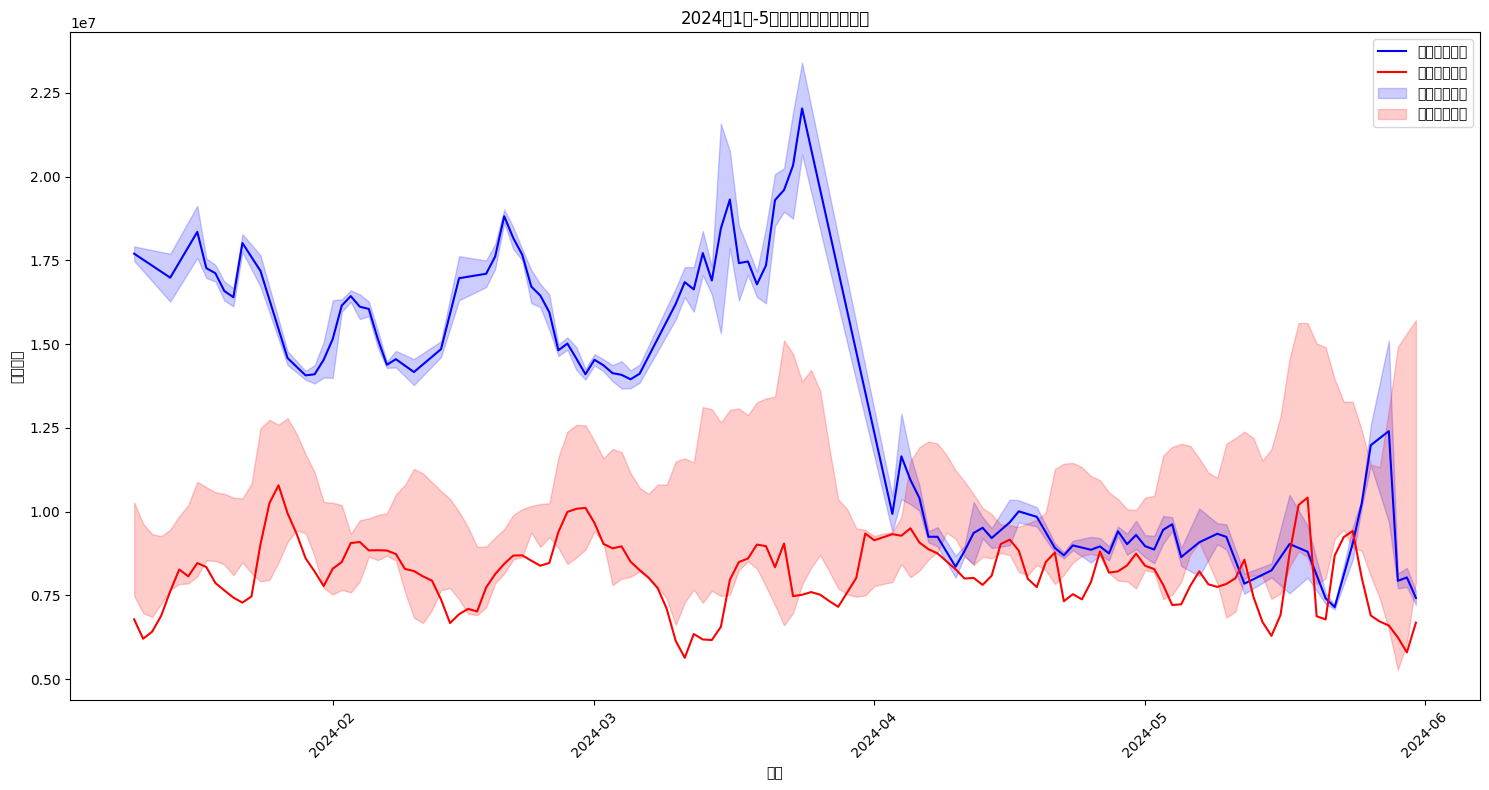

均方误差 (MSE): 44191741480622.73
平均绝对误差 (MAE): 5348638.77
平均绝对百分比误差 (MAPE): 34.56%
预测准确率: 0.00%


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# 读取2024年1月-5月的数据
df_2024 = pd.read_csv('特征结果_2024年1月-5月_插值填充.csv')
df_2024['date'] = pd.to_datetime(df_2024['date'])

# 准备特征数据
X_2024 = df_2024[['ndci', 'ndvi', 'evi', 'ndwi', 'b1', 'b2', 'b5']]

# 数据标准化
scaler_X = MinMaxScaler()
X_2024_scaled = scaler_X.fit_transform(X_2024)

# 创建时间窗口数据
def create_sequences(X, time_steps=10):
    Xs = []
    for i in range(len(X) - time_steps + 1):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)

X_2024_seq = create_sequences(X_2024_scaled)

import datetime

# 获取当前日期
current_date = datetime.datetime.now().strftime("%Y%m%d")

# 自定义对象字典
custom_objects = {'mse': tf.keras.losses.mse}

# 加载模型
lstm_model_mean = load_model(f'lstm_model_mean_{current_date}.h5', custom_objects=custom_objects)
lstm_model_lower = load_model(f'lstm_model_lower_{current_date}.h5', custom_objects=custom_objects)
lstm_model_upper = load_model(f'lstm_model_upper_{current_date}.h5', custom_objects=custom_objects)

# 进行预测
y_pred_mean = lstm_model_mean.predict(X_2024_seq)
y_pred_lower = lstm_model_lower.predict(X_2024_seq)
y_pred_upper = lstm_model_upper.predict(X_2024_seq)

# 反标准化预测结果
scaler_y = MinMaxScaler()
scaler_y.fit(df_2024['density_mean'].values.reshape(-1, 1))
y_pred_mean = scaler_y.inverse_transform(y_pred_mean)
y_pred_lower = scaler_y.inverse_transform(y_pred_lower)
y_pred_upper = scaler_y.inverse_transform(y_pred_upper)

# 准备绘图数据
dates = df_2024['date'][9:]  # 从第10天开始
actual_mean = df_2024['density_mean'][9:]
actual_lower = df_2024['density_lower'][9:]
actual_upper = df_2024['density_upper'][9:]

# 绘制结果图
plt.figure(figsize=(15, 8))
plt.plot(dates, actual_mean, label='实际平均密度', color='blue')
plt.plot(dates, y_pred_mean, label='预测平均密度', color='red')
plt.fill_between(dates, actual_lower, actual_upper, alpha=0.2, color='blue', label='实际密度范围')
plt.fill_between(dates, y_pred_lower.flatten(), y_pred_upper.flatten(), alpha=0.2, color='red', label='预测密度范围')

plt.title('2024年1月-5月藻华密度预测对比图')
plt.xlabel('日期')
plt.ylabel('藻华密度')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 输出统计信息
mse = np.mean((actual_mean - y_pred_mean.flatten())**2)
mae = np.mean(np.abs(actual_mean - y_pred_mean.flatten()))
mape = np.mean(np.abs((actual_mean - y_pred_mean.flatten()) / actual_mean)) * 100

print(f'均方误差 (MSE): {mse:.2f}')
print(f'平均绝对误差 (MAE): {mae:.2f}')
print(f'平均绝对百分比误差 (MAPE): {mape:.2f}%')

# 计算预测准确率
accuracy = np.mean((y_pred_lower.flatten() <= actual_mean) & (actual_mean <= y_pred_upper.flatten())) * 100
print(f'预测准确率: {accuracy:.2f}%')


请你读取这个模型和数据:
"""
# 保存模型
lstm_model_mean.save(f'lstm_model_mean_{current_date}.h5')
lstm_model_lower.save(f'lstm_model_lower_{current_date}.h5')
lstm_model_upper.save(f'lstm_model_upper_{current_date}.h5')

print(f"模型已保存（日期：{current_date}），可以在未来加载使用")
"""
并进行预测，绘制结果图，并输出一些统计信息。这里的LSTM的时间窗口是10天，也就是说，我们使用历史10天的数据，进行LSTM的时间卷积处理，来预测第10天的密度。最后绘制2024年的对比图，包括实际数据和预测数据